In [63]:
#Importing Necessary Libraries
import nltk
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk import pos_tag
import langid
import string
import re
nltk.download('wordnet')
import pandas as pd
import numpy as np


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

#Loading libraries required for model
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from wordcloud import WordCloud,STOPWORDS
from PIL import Image



[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jeyen\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# About the Dataset


### The Dataset was downloaded from https://www.kaggle.com/utathya/imdb-review-dataset
### Raw Data contains 100K reviews along with their sentiment labels

In [2]:
# Importing the dataset
data = pd.read_csv('D:/MSBA/Projects/imdb-review-dataset/imdb_master.csv',encoding='latin-1' )

In [3]:
# Checking the dataset imported
data.head()

,review,label,file
0,Once again Mr. Costner has dragged out a movie...,neg,0_2.txt
1,This is an example of why the majority of acti...,neg,10000_4.txt
2,"First of all I hate those moronic rappers, who...",neg,10001_1.txt
3,Not even the Beatles could write songs everyon...,neg,10002_3.txt
4,Brass pictures (movies is not a fitting word f...,neg,10003_3.txt


In [4]:
#dropping the irrelavant column 'file'
data = data.drop('file', axis = 1)

In [5]:
data['label'].value_counts()

unsup    50000
neg      25000
pos      25000
Name: label, dtype: int64

As we can see from above 50% of the labels are in the category "unsup". This might neither be positive or negative reviews. Thus we filter out these from our analysis and only consider positive-negative

In [6]:
#filter out the rows with label = 'unsup'
data_f = data[data['label'] != 'unsup']

In [7]:
data_f.count()

review    50000
label     50000
dtype: int64

In [8]:
data_f['label'].value_counts()

neg    25000
pos    25000
Name: label, dtype: int64

Now we have only positive and negative labels in our dataset. 
We have 50K reviews and its sentiment label (12500 pos and 12500 neg)

We perform data following preprocessing steps to have our text suitable for modeling:

Removal of non ASCII characters
Convert to lowercase
Remove hyperlinks
Remove @mentions
Remove puncuation
Remove numeric 'words'
Remove non a-z 0-9 characters and words shorter than 1 characters
Lemmatization


In [9]:
def strip_non_ascii(data_str):
    ''' Returns the string without non ASCII characters''' 
    stripped = (c for c in data_str if 0 < ord(c) < 127) 
    return ''.join(stripped)

In [10]:
def remove_features(data_str): # compile regex
    url_re = re.compile('https?://(www.)?\w+\.\w+(/\w+)*/?') 
    punc_re = re.compile('[%s]' % re.escape(string.punctuation)) 
    num_re = re.compile('(\\d+)')
    mention_re = re.compile('@(\w+)')
    alpha_num_re = re.compile("^[a-z0-9_.]+$")
    # convert to lowercase
    data_str = data_str.lower()
    # remove hyperlinks
    data_str = url_re.sub(' ', data_str)
    # remove @mentions
    data_str = mention_re.sub(' ', data_str)
    # remove puncuation
    data_str = punc_re.sub(' ', data_str)
    # remove numeric 'words'
    data_str = num_re.sub(' ', data_str)
    # remove non a-z 0-9 characters and words shorter than 1 characters 
    list_pos = 0
    cleaned_str = ''
    for word in data_str.split():
        if list_pos == 0:
            if alpha_num_re.match(word) and len(word) > 1:
                cleaned_str = word 
            else:
                cleaned_str = ' '
        else:
            if alpha_num_re.match(word) and len(word) > 1:
                cleaned_str = cleaned_str + ' ' + word 
            else:
                cleaned_str += ' '
        list_pos += 1
    
    return " ".join(cleaned_str.split())

In [11]:
def lemmatize(data_str):
    # expects a string
    list_pos = 0
    cleaned_str = ''
    lmtzr = WordNetLemmatizer() 
    text = data_str.split() 
    tagged_words = pos_tag(text) 
    for word in tagged_words:
        if 'v' in word[1].lower():
            lemma = lmtzr.lemmatize(word[0], pos='v')
        else:
            lemma = lmtzr.lemmatize(word[0], pos='n')
        if list_pos == 0: 
            cleaned_str = lemma
        else:
            cleaned_str = cleaned_str + ' ' + lemma
        list_pos += 1 
    return cleaned_str

In [12]:
#Checking for the first review in our dataset
data_f['review'][1]

"This is an example of why the majority of action films are the same. Generic and boring, there's really nothing worth watching here. A complete waste of the then barely-tapped talents of Ice-T and Ice Cube, who've each proven many times over that they are capable of acting, and acting well. Don't bother with this one, go see New Jack City, Ricochet or watch New York Undercover for Ice-T, or Boyz n the Hood, Higher Learning or Friday for Ice Cube and see the real deal. Ice-T's horribly cliched dialogue alone makes this film grate at the teeth, and I'm still wondering what the heck Bill Paxton was doing in this film? And why the heck does he always play the exact same character? From Aliens onward, every film I've seen with Bill Paxton has him playing the exact same irritating character, and at least in Aliens his character died, which made it somewhat gratifying...<br /><br />Overall, this is second-rate action trash. There are countless better films to see, and if you really want to s

In [13]:
# Cleaning the Data
clean_data = []
for i in range(len(data_f)):
    res = remove_features(data_f['review'][i])
    res1 = strip_non_ascii(res)
    res2 = lemmatize(res1)
    clean_data.append(res2)

Now we have clean data reviews in the form a list.

As a next step we will create a dataframe with the cleaned reviews and its label

In [14]:
review_clean = pd.DataFrame(clean_data, columns = ['Reviews'])
reviews_data = pd.concat([review_clean, data_f['label']], axis = 1)

In [15]:
reviews_data.iloc[:1]

,Reviews,label
0,once again mr costner have drag out movie for ...,neg


In [16]:
#Split the data into training and test 70-30

from sklearn.model_selection import train_test_split
train, test = train_test_split(reviews_data, test_size=0.3, random_state=42)
#Train: 35000
#Test:  15000

# Data Transformation 

We have divided the data transformation into different parts:
CountVectorizer using unigram (i.e In this vectorizer is done splitting into one word)
CountVectorizer using ngram (i.e In this vectorizer is done splitting into two or more words)
TFIDF Vectorizer using unigram
TFIDF Vectorizer using ngram

We now run for Count Vectorizer unigram

In [17]:
#Count Vectorizer - unigram
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words='english')
X_train_cv_unigram = cv.fit_transform(train['Reviews'])
X_test_cv_unigram = cv.transform(test['Reviews']) 

In [20]:
#Count Vectorizer - ngram
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words='english', binary = True, ngram_range = (1,2))
X_train_cv_ngram = cv.fit_transform(train['Reviews'])
X_test_cv_ngram = cv.transform(test['Reviews']) 
#print(X_test_cv_ngram.toarray().shape)

In [41]:
# Running Multinomial Naive Bayes
# We have created a function for Naive Bayes to try different alpha values.
   
def NB1(train_data, test_data, heading):
    print (heading)
    for c in [1,0.1,0.01,0.001,0.0001,0.00001,0]:
        nb_multi = MultinomialNB(alpha = c)
        nb_multi.fit(train_data, train['label'])
        y_pred_nb = nb_multi.predict(test_data)
        print ("Accuracy for test C=%s: %s"
               % (c, accuracy_score(test['label'], nb_multi.predict(test_data))))

In [42]:
NB1(X_train_cv_unigram, X_test_cv_unigram,"Naive Bayes: Count Vectorizer unigram")

Naive Bayes: Count Vectorizer unigram
Accuracy for test C=1: 0.856
Accuracy for test C=0.1: 0.8545333333333334
Accuracy for test C=0.01: 0.8474666666666667
Accuracy for test C=0.001: 0.8404
Accuracy for test C=0.0001: 0.8346
Accuracy for test C=1e-05: 0.8284666666666667
Accuracy for test C=0: 0.8066


C:\Users\jeyen\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


In [43]:
NB1(X_train_cv_ngram, X_test_cv_ngram,"Naive Bayes: Count Vectorizer ngram")

Naive Bayes: Count Vectorizer ngram
Accuracy for test C=1: 0.8786
Accuracy for test C=0.1: 0.8745333333333334
Accuracy for test C=0.01: 0.8628
Accuracy for test C=0.001: 0.8509333333333333
Accuracy for test C=0.0001: 0.8422666666666667
Accuracy for test C=1e-05: 0.8358


C:\Users\jeyen\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Accuracy for test C=0: 0.8212666666666667


In [44]:
# Logistic Regression for different c values which takes care of regularization
def LR(train_data, test_data, heading):
    print (heading)
    for c in [0.01, 0.05, 0.25, 0.5, 1]:
        lr = LogisticRegression(C=c)
        lr.fit(train_data, train['label'])
        print ("Accuracy for test C=%s: %s" 
           % (c, accuracy_score(test['label'], lr.predict(test_data))))

In [45]:
LR(X_train_cv_unigram, X_test_cv_unigram, "Logistic: Count Vectorizer unigram")

Logistic: Count Vectorizer unigram


C:\Users\jeyen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy for test C=0.01: 0.8840666666666667
Accuracy for test C=0.05: 0.8881333333333333
Accuracy for test C=0.25: 0.8878666666666667
Accuracy for test C=0.5: 0.8870666666666667
Accuracy for test C=1: 0.8839333333333333


In [46]:
LR(X_train_cv_ngram, X_test_cv_ngram, "Logistic: Count Vectorizer ngram")

Logistic: Count Vectorizer ngram
Accuracy for test C=0.01: 0.8822666666666666
Accuracy for test C=0.05: 0.8899333333333334
Accuracy for test C=0.25: 0.8922
Accuracy for test C=0.5: 0.8926
Accuracy for test C=1: 0.8916666666666667


In [47]:
# Support Vector Machines with different values of c
def SVM(train_data, test_data, heading):
    print (heading)
    for c in [0.01, 0.05, 0.25, 0.5, 1]:
        svm = LinearSVC(C=c)
        svm.fit(train_data, train['label'])
        print ("Accuracy for test C=%s: %s"
               % (c, accuracy_score(test['label'], svm.predict(test_data))))

In [48]:
SVM(X_train_cv_unigram, X_test_cv_unigram, "SVM: Count Vectorizer unigram")

SVM: Count Vectorizer unigram
Accuracy for test C=0.01: 0.8883333333333333


C:\Users\jeyen\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy for test C=0.05: 0.8836


C:\Users\jeyen\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy for test C=0.25: 0.8714


C:\Users\jeyen\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy for test C=0.5: 0.8658666666666667
Accuracy for test C=1: 0.8618


C:\Users\jeyen\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [49]:
SVM(X_train_cv_ngram, X_test_cv_ngram, "SVM: Count Vectorizer ngram")

SVM: Count Vectorizer ngram
Accuracy for test C=0.01: 0.8922666666666667
Accuracy for test C=0.05: 0.891
Accuracy for test C=0.25: 0.8897333333333334


C:\Users\jeyen\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy for test C=0.5: 0.8889333333333334
Accuracy for test C=1: 0.8886


C:\Users\jeyen\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Comapring the above models on the basis of accuracy and ngram or unigram method we can see that all the three models works better on ngram for Count Vectorizer technique. 

Ngrams are those which uses more than on one word in the model to identify the sentiments. Thus if we use unigram then the review that contains "it is not nice" might end up in positive category as the word nice is highly correlated to positive however if we use ngram then "not nice" will be considered as sequence of words thus can give accurate classification

As a next step will now consider another Vectorizer method i.e. TFIDF unigram and ngram for these models

In [28]:
#Creating a TFIDF vectorizer unigram
tv = TfidfVectorizer(stop_words="english",min_df = 0.01, max_df = 0.85)
train_tv_unigram = tv.fit_transform(train['Reviews']).todense()
test_tv_unigram = tv.transform(test['Reviews'])

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.10914071, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.13705514, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [29]:
#Creating a TFIDF vectorizer ngram
tv = TfidfVectorizer(stop_words="english",min_df = 0.01, max_df = 0.85,  ngram_range = (1,2))
train_tv_ngram = tv.fit_transform(train['Reviews']).todense()
test_tv_ngram = tv.transform(test['Reviews'])

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.10767977, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.13590813, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [50]:
NB1(train_tv_unigram, test_tv_unigram,"Naive Bayes: TFIDF unigram")

Naive Bayes: TFIDF unigram
Accuracy for test C=1: 0.8428
Accuracy for test C=0.1: 0.8426666666666667
Accuracy for test C=0.01: 0.8428
Accuracy for test C=0.001: 0.8428
Accuracy for test C=0.0001: 0.8428
Accuracy for test C=1e-05: 0.8428
Accuracy for test C=0: 0.8428


C:\Users\jeyen\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


In [51]:
NB1(train_tv_ngram, test_tv_ngram,"Naive Bayes: TFIDF ngram") 

Naive Bayes: TFIDF ngram
Accuracy for test C=1: 0.844
Accuracy for test C=0.1: 0.8442666666666667
Accuracy for test C=0.01: 0.8444
Accuracy for test C=0.001: 0.8444
Accuracy for test C=0.0001: 0.8444
Accuracy for test C=1e-05: 0.8444
Accuracy for test C=0: 0.8444


C:\Users\jeyen\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


In [52]:
LR(train_tv_unigram, test_tv_unigram, "Logistic: TFIDF unigram")

C:\Users\jeyen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logistic: TFIDF unigram
Accuracy for test C=0.01: 0.8254666666666667


C:\Users\jeyen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy for test C=0.05: 0.8515333333333334


C:\Users\jeyen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy for test C=0.25: 0.8660666666666667


C:\Users\jeyen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy for test C=0.5: 0.8693333333333333


C:\Users\jeyen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy for test C=1: 0.8719333333333333


In [53]:
LR(train_tv_ngram, test_tv_ngram, "Logistic: TFIDF ngram")

Logistic: TFIDF ngram


C:\Users\jeyen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy for test C=0.01: 0.8254666666666667


C:\Users\jeyen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy for test C=0.05: 0.8528666666666667


C:\Users\jeyen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy for test C=0.25: 0.8668


C:\Users\jeyen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy for test C=0.5: 0.8702


C:\Users\jeyen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy for test C=1: 0.8723333333333333


In [54]:
SVM(train_tv_unigram, test_tv_unigram, "SVM: TFIDF unigram")

SVM: TFIDF unigram
Accuracy for test C=0.01: 0.8589333333333333
Accuracy for test C=0.05: 0.8698666666666667
Accuracy for test C=0.25: 0.8699333333333333
Accuracy for test C=0.5: 0.8688
Accuracy for test C=1: 0.869


In [55]:
SVM(train_tv_ngram, test_tv_ngram, "SVM: TFIDF ngram")

SVM: TFIDF ngram
Accuracy for test C=0.01: 0.86
Accuracy for test C=0.05: 0.8703333333333333
Accuracy for test C=0.25: 0.8712
Accuracy for test C=0.5: 0.8699333333333333
Accuracy for test C=1: 0.8688


SImilarly by comparing both unigram and ngram of TFIDF method we can observe that ngram performs better than unigram in this TFIDF as well, which is again no suprise for the reason explained earlier.

Now as a final step we pick the model that gives the best accuracy.

By comparing the results we can conclude that Naive Bayes does not perform well compared to the Logistic and SVM. 
In terms of accuracy we can see that Logistic Regression from Count Vectorizer ngram at c = 0.5 performs the best with 89.3% accuracy on test data.

We now look at the result of this particular model through confusion matrix in order to understand in more detail

Logistic Regression CV ngram c - 0.5
Accuracy: 0.893
Precision: 0.881
Recall: 0.905
F1 Score: 0.893


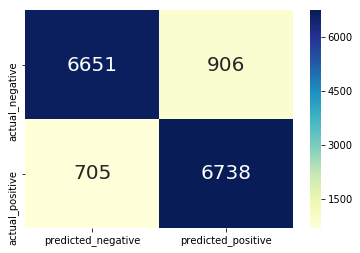

In [57]:
# Creating function for the model and error metrices
lr = LogisticRegression(C = 0.5)
lr.fit(X_train_cv_ngram, train['label'])
y_pred_lr = lr.predict(X_test_cv_ngram)

    
def cm1(test_label, test_pred, Results):


    # Apply the model on the test data and calculate the following error metrics: accuracy, precision, recall, F1 score

    cm = confusion_matrix(test_label, test_pred)
    sns.heatmap(cm, xticklabels=['predicted_negative', 'predicted_positive'], yticklabels=['actual_negative', 'actual_positive'],
    annot=True, fmt='d', annot_kws={'fontsize':20}, cmap="YlGnBu");
    true_neg, false_pos = cm[0]
    false_neg, true_pos = cm[1]
    accuracy = round((true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg),3)
    precision = round((true_pos) / (true_pos + false_pos),3)
    recall = round((true_pos) / (true_pos + false_neg),3)
    f1 = round(2 * (precision * recall) / (precision + recall),3)

    
    print(Results)
    print('Accuracy: {}'.format(accuracy))
    print('Precision: {}'.format(precision))
    print('Recall: {}'.format(recall))
    print("F1 Score: {}".format(f1))

cm1(test['label'], y_pred_lr, "Logistic Regression CV ngram c - 0.5")

### Word Cloud for sentiment labels

In [58]:
pos_string = reviews_data[reviews_data.label == 'pos']['Reviews'].str.cat(sep=' ')

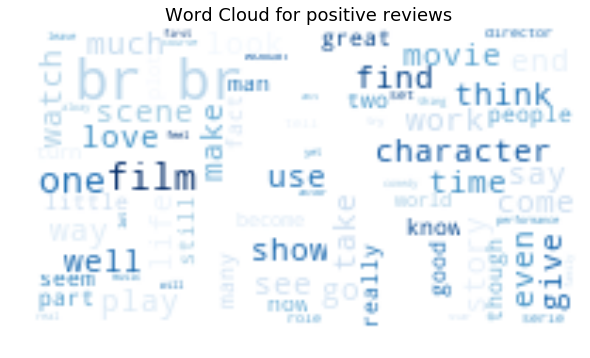

In [65]:
twitter_mask = np.array(Image.open("D:/MSBA/Projects/logo.jpg"))
wc = WordCloud(width=1600, height=800,background_color="white", colormap="Blues",mask=twitter_mask).generate(pos_string)
plt.figure(figsize=(8,8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.title('Word Cloud for positive reviews', fontsize=18)
plt.show()

In [66]:
pos_string = reviews_data[reviews_data.label == 'neg']['Reviews'].str.cat(sep=' ')

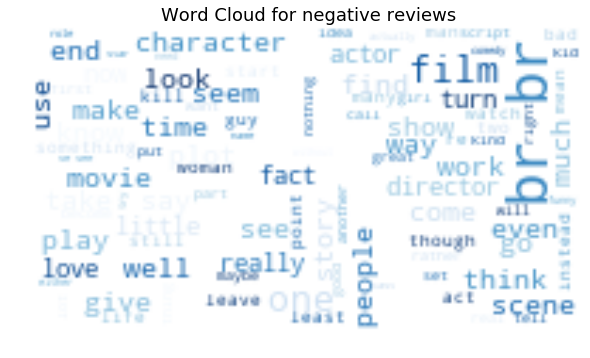

In [67]:
twitter_mask = np.array(Image.open("D:/MSBA/Projects/logo.jpg"))
wc = WordCloud(width=1600, height=800,background_color="white", colormap="Blues",mask=twitter_mask).generate(pos_string)
plt.figure(figsize=(8,8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.title('Word Cloud for negative reviews', fontsize=18)
plt.show()